# Exploring PyTorch Lightning for Classifying MNIST Handwritten Digits

---

__Elliott Forney - 2021__

In [1]:
import torch as th
import torchvision as tv
import pytorch_lightning as pl

import skimage as ski

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (9, 8)

In [2]:
#images = np.stack([train_data[i][0] for i in range(16)])
#montage = ski.util.montage(images)
#plt.imshow(montage, cmap=plt.cm.gray_r);
#plt.axis('off');

In [24]:
datadir = '../data/torchvision/'

class MNISTData(pl.LightningDataModule):
    def __init__(self, batch_size=1024, num_workers=10):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
    
    def prepare_data(self):
        tv.datasets.MNIST(datadir, download=True)
        tv.datasets.MNIST(datadir, download=True)
    
    def setup(self, stage=None):        
        all_train_data = tv.datasets.MNIST(
            datadir,
            transform=tv.transforms.ToTensor(),
            train=True)
        self.train_data, self.valid_data = th.utils.data.random_split(
            all_train_data, (50_000, 10_000))
        
        self.test_data = tv.datasets.MNIST(
            datadir,
            transform=tv.transforms.ToTensor(),
            train=False)
        
    def plot_montage(self, n=16):
        images = np.stack([self.valid_data[i][0] for i in range(n)])
        montage = ski.util.montage(images)
        fig, ax = plt.subplots()
        ax.imshow(montage, cmap=plt.cm.gray_r)
        ax.axis('off')
        return {
            'fig': fig,
            'ax': ax,
        }
    
    def train_dataloader(self):
        return th.utils.data.DataLoader(
            self.train_data,
            batch_size=self.batch_size,
            pin_memory=True,
            num_workers=self.num_workers,
            drop_last=True,
            shuffle=True)
    
    def val_dataloader(self):
        return th.utils.data.DataLoader(
            self.valid_data,
            batch_size=self.batch_size,
            pin_memory=True,
            num_workers=self.num_workers,
            drop_last=False,
            shuffle=False)
    
    def test_dataloader(self):
        return th.utils.data.DataLoader(
            self.test_data,
            batch_size=self.batch_size,
            pin_memory=True,
            num_workers=self.num_workers,
            drop_last=False,
            shuffle=False)

In [25]:
mnist_data = MNISTData()

In [27]:
mnist_data.train_dataloader()

AttributeError: 'MNISTData' object has no attribute 'train_data'

In [5]:
class DenseNet(pl.LightningModule):
    def __init__(self, height=28, width=28, nclass=10, nhiddens=(128, 64, 32)):
        super().__init__()
        
        self.height, self.width = height, width
        self.nclass = nclass
        self.nhiddens = nhiddens
        
        hiddens = []
        layer_in, layer_out = None, self.height * self.width
        for nhidden in self.nhiddens:
            layer_in, layer_out = layer_out, nhidden
            hiddens.extend([
                th.nn.BatchNorm1d(layer_in),
                th.nn.Linear(layer_in, layer_out),
                th.nn.ReLU(),
            ])
        self.hiddens = th.nn.Sequential(*hiddens)
        
        layer_in, layer_out = layer_out, nclass
        self.visible = th.nn.Linear(layer_in, layer_out)
        
        self.train_accuracy = pl.metrics.Accuracy()
        self.valid_accuracy = pl.metrics.Accuracy()
        self.test_accuracy = pl.metrics.Accuracy()
        
    def forward(self, imgs):
        assert imgs.ndim == 4
        assert imgs.shape[1] == 1
        assert imgs.shape[2] == self.height
        assert imgs.shape[3] == self.width
        batch_size = imgs.shape[0]
        
        flat_imgs = imgs.view((batch_size, -1))
        hidden_out = self.hiddens(flat_imgs)
        assert hidden_out.shape == (batch_size, self.nhiddens[-1])
        
        visible_out = self.visible(hidden_out)
        assert visible_out.shape == (batch_size, self.nclass)
        
        return visible_out
    
    def predict(self, batch, batch_idx=None, dataloader_idx=None):
        imgs, labels = batch
        #return th.softmax(self(imgs), dim=1)
        return self(imgs).argmax(1)
    
    def configure_optimizers(self):
        return th.optim.Adam(self.parameters(), lr=0.0015)
    
    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = th.nn.functional.cross_entropy(logits, labels)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        
        probs = th.softmax(logits, dim=1)
        train_acc_step = self.train_accuracy(probs, labels)
        self.log('train_acc_step', train_acc_step, on_step=True, on_epoch=False)
        
        return {'loss': loss}
    
    def training_epoch_end(self, outputs):
        self.log('train_acc_epoch', self.train_accuracy.compute(), prog_bar=True)

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = th.nn.functional.cross_entropy(logits, labels)
        self.log('valid_loss_epoch', loss, on_step=False, on_epoch=True, prog_bar=True)
        
        probs = th.softmax(logits, dim=1)
        valid_acc_step = self.valid_accuracy(probs, labels)
        self.log('valid_acc_step', valid_acc_step, on_step=False, on_epoch=False)
        
        return {'loss': loss}
    
    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = th.nn.functional.cross_entropy(logits, labels)
        self.log('test_loss', loss)
        
        probs = th.softmax(logits, dim=1)
        test_acc_step = self.test_accuracy(probs, labels)
        self.log('test_acc', test_acc_step)
        
        return {'loss': loss}
    
    def validation_epoch_end(self, outputs):
        self.log('valid_acc_epoch', self.valid_accuracy.compute(), prog_bar=True)

In [6]:
dense_model = DenseNet()
dense_model

DenseNet(
  (hiddens): Sequential(
    (0): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
  )
  (visible): Linear(in_features=32, out_features=10, bias=True)
  (train_accuracy): Accuracy()
  (valid_accuracy): Accuracy()
  (test_accuracy): Accuracy()
)

In [7]:
import tqdm

class ProgressBar(pl.callbacks.progress.ProgressBar):
    def init_train_tqdm(self):        
        bar = tqdm.notebook.tqdm(
            desc='Training',
            initial=self.train_batch_idx,
            position=(2 * self.process_position),
            disable=self.is_disabled,
            leave=True,
            dynamic_ncols=True,
            file=sys.stdout,
            smoothing=0)        
        return bar
    
    def init_validation_tqdm(self):
        bar = tqdm.notebook.tqdm(
            desc='Validating',
            position=(2 * self.process_position + 1),
            disable=self.is_disabled,
            leave=False,
            dynamic_ncols=True,
            file=sys.stdout
        )
        return bar

In [8]:
import shutil
shutil.rmtree('./lightning_logs/', ignore_errors=True)

In [9]:
callbacks = [
    pl.callbacks.early_stopping.EarlyStopping(monitor='valid_loss_epoch', patience=10, verbose=True),
    #ProgressBar(),
]
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=callbacks,
    log_every_n_steps=1,
    check_val_every_n_epoch=1,
    progress_bar_refresh_rate=1,
    gpus=1)

EarlyStopping mode set to min for monitoring valid_loss_epoch.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [10]:
train_result = trainer.fit(dense_model, mnist_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | hiddens        | Sequential | 112 K 
1 | visible        | Linear     | 330   
2 | train_accuracy | Accuracy   | 0     
3 | valid_accuracy | Accuracy   | 0     
4 | test_accuracy  | Accuracy   | 0     
----------------------------------------------
113 K     Trainable params
0         Non-trainable params
113 K     Total params
0.452     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [11]:
train_result

1

In [12]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 118597), started 23:47:43 ago. (Use '!kill 118597' to kill it.)

In [13]:
trainer.test(dense_model, datamodule=mnist_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9721999764442444, 'test_loss': 0.10368657112121582}
--------------------------------------------------------------------------------


[{'test_loss': 0.10368657112121582, 'test_acc': 0.9721999764442444}]

In [29]:
preds = trainer.predict(dense_model, datamodule=mnist_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 48it [00:00, ?it/s]

In [30]:
np.concatenate(preds).shape

(10000,)

In [31]:
test_image, test_label = mnist_data.test_data[0]

7

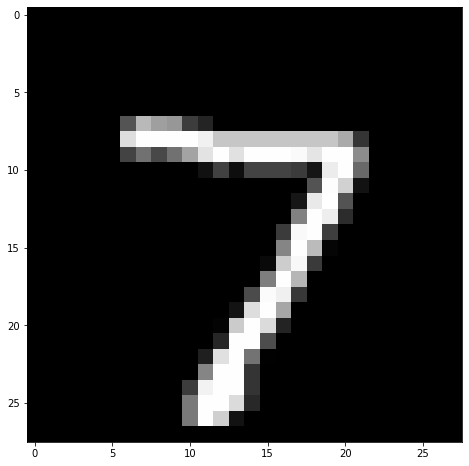

In [32]:
plt.imshow(test_image.squeeze(0), cmap=plt.cm.gray);
test_label

In [ ]:
#images = np.stack([train_data[i][0] for i in range(16)])
#montage = ski.util.montage(images)
#plt.imshow(montage, cmap=plt.cm.gray_r);
#plt.axis('off');